# Feature engineering:

Consolidate and transform features to improve modeling results.

In [33]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.decomposition import PCA
from scipy import stats
from scipy.special import boxcox

# plt.style.use('bmh')

In [113]:
# import compensation dataset that I have cleaned & reduced in the  prior notebook
df = pd.read_csv('02.data/model_dataset.csv')

In [114]:
df.head()

,reportable_comp,subsection,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_categories,total_ex_comp_per_company,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,cluster_label
0,198085.0,501(c)(6),ME,1995,734264,650527.0,1608376.0,1638630.0,56277,"Public, Societal Benefit",198085,79,79,10,0,1052040,0,False,False,7,181
1,87550.0,501(c)(6),ME,1911,173021,89089.0,632341.0,603122.0,56277,"Public, Societal Benefit",87550,20,20,8,100,397835,0,True,True,10,15
2,64575.0,501(c)(3),ME,1896,2283338,49470.0,846299.0,941058.0,56277,"Arts, Culture, and Humanities",64575,17,17,6,50,215850,0,True,True,8,62
3,62180.0,501(c)(6),ME,1927,17316,0.0,208615.0,183721.0,56277,"Public, Societal Benefit",62180,19,19,3,4,129714,0,True,True,9,59
4,130513.0,501(c)(6),ME,1952,831930,314175.0,1021331.0,1143753.0,56277,"Public, Societal Benefit",130513,31,31,9,145,539848,0,True,True,12,180


### FEATURE ENGINEERING

#### Categorical features

In [115]:
# what are my categorical features
df.select_dtypes(include=['object']).head()

,subsection,state,ntee_categories
0,501(c)(6),ME,"Public, Societal Benefit"
1,501(c)(6),ME,"Public, Societal Benefit"
2,501(c)(3),ME,"Arts, Culture, and Humanities"
3,501(c)(6),ME,"Public, Societal Benefit"
4,501(c)(6),ME,"Public, Societal Benefit"


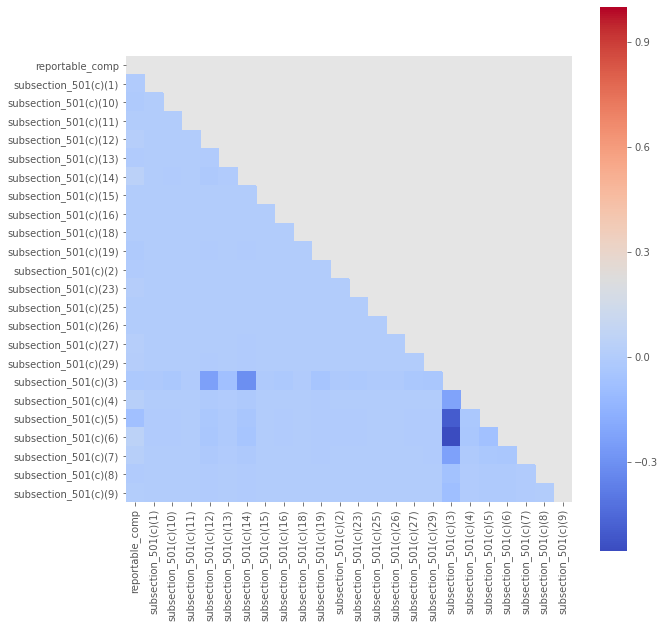

In [116]:
# show correlation heatmap comparing 
# target feature against subsection
plt.figure(figsize=(10, 10))

mask = np.zeros_like(pd.get_dummies(df[['reportable_comp', 'subsection']]).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(pd.get_dummies(df[['reportable_comp', 'subsection']]).corr(),
            cmap='coolwarm',
            annot=False,
            square=True,
            mask = mask);

501c3 clearly seems to have the strongest relationship with other features.

In [117]:
# based on visual inspection above
# identify features to be combined
pd.get_dummies(df[['reportable_comp', 'subsection']]).corr().abs() \
.loc[:,'subsection_501(c)(3)'].sort_values(ascending=False).head(7).index

Index(['subsection_501(c)(3)', 'subsection_501(c)(6)', 'subsection_501(c)(5)',
       'subsection_501(c)(14)', 'subsection_501(c)(12)',
       'subsection_501(c)(7)', 'subsection_501(c)(4)'],
      dtype='object')

The top 7 seem to be quite closely related.

In [118]:
# concolidate subsections
for cat in pd.get_dummies(df[['reportable_comp', 'subsection']]).corr().abs() \
.loc[:,'subsection_501(c)(3)'].sort_values(ascending=False).head(7).index:
    df[cat] = df.subsection == cat

In [119]:
df.head()

,reportable_comp,subsection,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_categories,total_ex_comp_per_company,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,cluster_label,subsection_501(c)(3),subsection_501(c)(6),subsection_501(c)(5),subsection_501(c)(14),subsection_501(c)(12),subsection_501(c)(7),subsection_501(c)(4)
0,198085.0,501(c)(6),ME,1995,734264,650527.0,1608376.0,1638630.0,56277,"Public, Societal Benefit",198085,79,79,10,0,1052040,0,False,False,7,181,False,False,False,False,False,False,False
1,87550.0,501(c)(6),ME,1911,173021,89089.0,632341.0,603122.0,56277,"Public, Societal Benefit",87550,20,20,8,100,397835,0,True,True,10,15,False,False,False,False,False,False,False
2,64575.0,501(c)(3),ME,1896,2283338,49470.0,846299.0,941058.0,56277,"Arts, Culture, and Humanities",64575,17,17,6,50,215850,0,True,True,8,62,False,False,False,False,False,False,False
3,62180.0,501(c)(6),ME,1927,17316,0.0,208615.0,183721.0,56277,"Public, Societal Benefit",62180,19,19,3,4,129714,0,True,True,9,59,False,False,False,False,False,False,False
4,130513.0,501(c)(6),ME,1952,831930,314175.0,1021331.0,1143753.0,56277,"Public, Societal Benefit",130513,31,31,9,145,539848,0,True,True,12,180,False,False,False,False,False,False,False


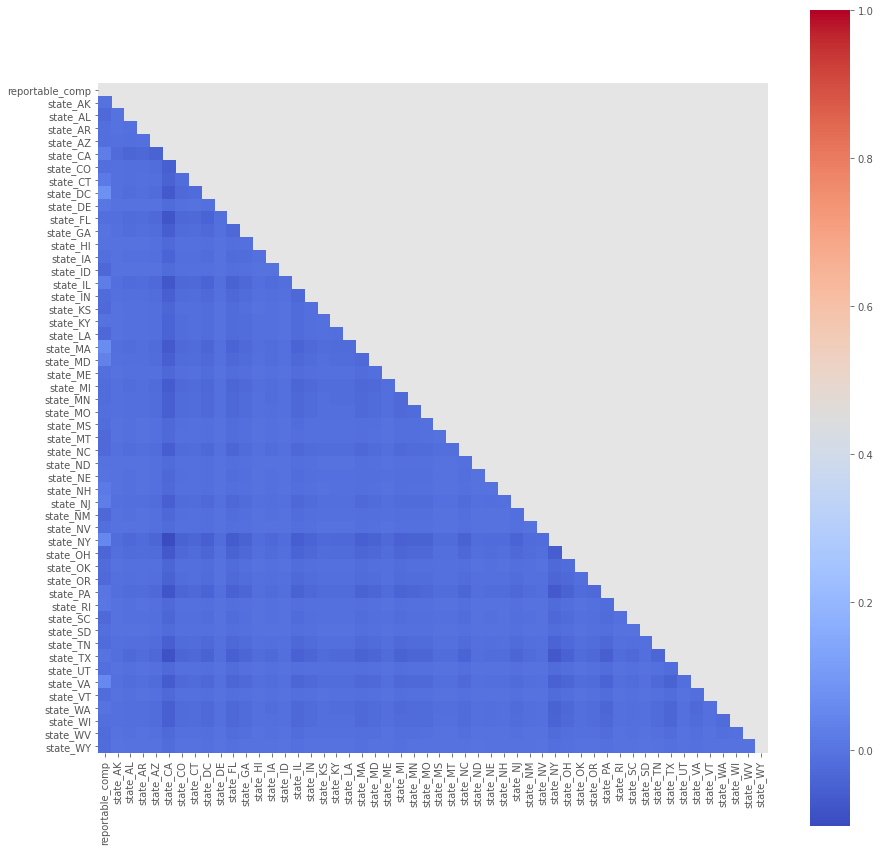

In [120]:
# show correlation heatmap comparing 
# target feature against state
plt.figure(figsize=(15, 15))

mask = np.zeros_like(pd.get_dummies(df[['reportable_comp', 'state']]).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(pd.get_dummies(df[['reportable_comp', 'state']]).corr(),
            cmap='coolwarm',
            annot=False,
#             vmin=-1,
            square=True,
            mask = mask);

Some states seem to be negatively and positively correlated with reportable compensation.

In [121]:
# positively correlated states
pd.get_dummies(df[['reportable_comp', 'state']]).corr() \
.loc[:,'reportable_comp'].sort_values(ascending=False).head(10)

reportable_comp    1.000000
state_DC           0.076012
state_MA           0.065091
state_VA           0.053791
state_NY           0.051975
state_MD           0.038223
state_IL           0.026317
state_NJ           0.024588
state_CA           0.023502
state_CT           0.015895
Name: reportable_comp, dtype: float64

In [122]:
# consolidate positively correlated states
# using pca
sklearn_pca = PCA(n_components=2)

sklearn_pca.fit_transform(pd.get_dummies(df[['reportable_comp', 'state']])[pd.get_dummies(df[['reportable_comp', 'state']]).corr() \
.loc[:,'reportable_comp'].sort_values(ascending=False).head(10).index].iloc[:, 1:])

sklearn_pca.explained_variance_ratio_

array([0.28887782, 0.19279878])

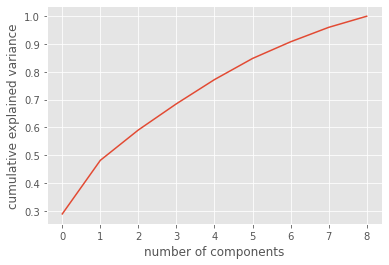

In [123]:
pca = PCA().fit(pd.get_dummies(df[['reportable_comp', 'state']])[pd.get_dummies(df[['reportable_comp', 'state']]).corr() \
.loc[:,'reportable_comp'].sort_values(ascending=False).head(10).index].iloc[:, 1:])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [124]:
df = pd.concat([
    pd.DataFrame(data = sklearn_pca.fit_transform(pd.get_dummies(df[['reportable_comp', 'state']])[pd.get_dummies(df[['reportable_comp', 'state']]).corr() \
.loc[:,'reportable_comp'].sort_values(ascending=False).head(10).index].iloc[:, 1:]), 
             columns = ['pca_states_pos_1', 
                      'pca_states_pos_2']),
    df], axis=1)

In [125]:
# based on visual inspection above
# identify features to be combined
pd.get_dummies(df['state']).corr() \
    .loc[:,'CA'].sort_values(ascending=False).head(10)

CA    1.000000
WY   -0.016398
DE   -0.021016
ID   -0.021716
SD   -0.022466
AK   -0.022561
NV   -0.023192
ND   -0.023215
HI   -0.025013
NH   -0.025564
Name: CA, dtype: float64

However, some states have a negative correlation with reportable compensation.

In [126]:
# consolidate negatively correlated states
# using pca
sklearn_pca = PCA(n_components=2)

sklearn_pca.fit_transform(pd.get_dummies(df['state'])[['CA', 'WY', 'DE', 'ID', 'AK', 'NV', 'SD', 'ND', 'HI']])

sklearn_pca.explained_variance_ratio_

array([0.7686926 , 0.03707118])

Explained variance is quite high for these negatively correlated states.  I am capturing some state specific information in the median age feature for each state.  However, some of these states have high standards of living, yet a negative correlation to reportable compensation.

In [127]:
sklearn_pca = PCA(n_components=1)

df['pca_states_neg'] = sklearn_pca.fit_transform(
    pd.get_dummies(df['state'])[['CA', 'WY', 'DE', 'ID', 'AK', 'NV', 'SD', 'ND', 'HI']])

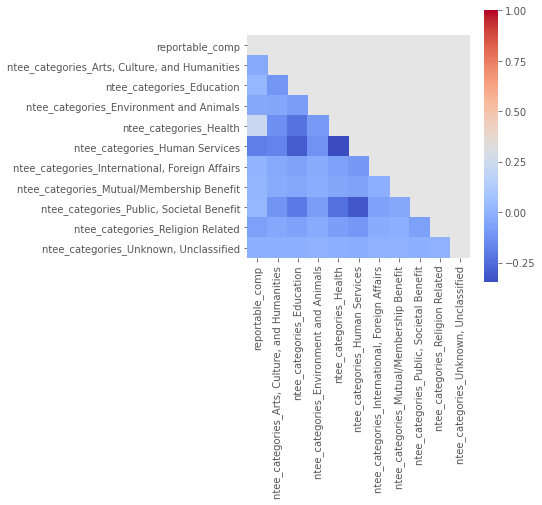

In [128]:
# show correlation heatmap comparing 
# target feature against ntee categories
plt.figure(figsize=(5, 5))

mask = np.zeros_like(pd.get_dummies(df[['reportable_comp', 'ntee_categories']]).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(pd.get_dummies(df[['reportable_comp', 'ntee_categories']]).corr(),
            cmap='coolwarm',
            annot=False,
#             vmin=-1,
            square=True,
            mask = mask);

Since I'm seeing quite a bit of distribution in correlation for this feature, I will not consolidate with PCA.

In [129]:
# drop features that have been
# consolidated with PCA
df.drop(['state',
       'subsection'], axis=1, inplace=True)

### Continuous features correlations

Because of the strong skew in continuous features, I will windsorize outliers and transform with box-cox.

In [130]:
for column in df[['assets', 
               'liabilities', 
               'employee_tot_ct', 
               'revenue', 
               'salaries_expense_tot_curyr', 
               'expenses', 
               'total_ex_comp_per_company']].columns:
    df[column].clip(upper=df[column].quantile(.95), inplace=True)

In [131]:
# box-cox requires only positive values
# how many organizations are there with negative values?
# for column in df[['assets', 
#                'liabilities', 
#                'employee_tot_ct', 
#                'revenue', 
#                'salaries_expense_tot_curyr', 
#                'expenses', 
#                'total_ex_comp_per_company']].columns:
#     if df[df[column] <= 0].shape[0] > 0:
#         print(column + ' -', df[df[column] <= 0].shape[0])

In [132]:
# drop compensation with negative values
# for column in df[['assets', 
#                'liabilities', 
#                'employee_tot_ct', 
#                'revenue', 
#                'salaries_expense_tot_curyr', 
#                'expenses', 
#                'total_ex_comp_per_company']].columns:
#     if df[df[column] <= 0].shape[0] > 0:
#         df.drop(df[df[column] <= 0].index, axis=0, inplace=True)

In [133]:
# transform features with boxcox
# for column in df[['assets', 
#                'liabilities', 
#                'employee_tot_ct', 
#                'revenue', 
#                'salaries_expense_tot_curyr', 
#                'expenses', 
#                'total_ex_comp_per_company']].columns:
#     df[column] = stats.boxcox(df[column])[0]

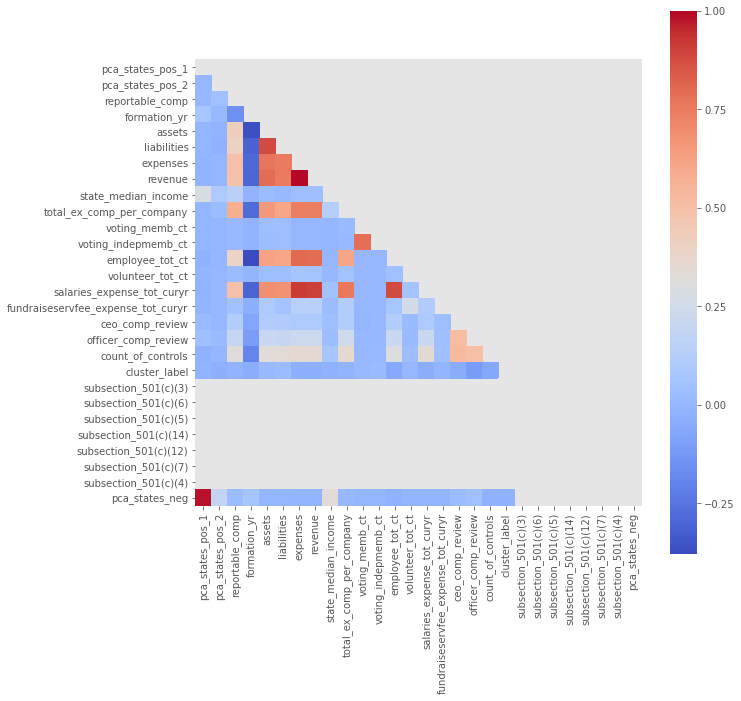

In [134]:
plt.figure(figsize=(10, 10))

mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df.corr(),
            cmap='coolwarm',
#             cmap="Blues",
            annot=False,
            square=True,
            mask = mask);

A number of continuous features are very strongly positively correlated with reportable compensation.

In [135]:
# based on visual inspection above
# identify features to be combined
df.corr().loc[:,'assets'].sort_values(ascending=False).head(10)

assets                        1.000000
liabilities                   0.880505
revenue                       0.790305
expenses                      0.769966
salaries_expense_tot_curyr    0.688286
total_ex_comp_per_company     0.657870
employee_tot_ct               0.627543
reportable_comp               0.428256
count_of_controls             0.335748
officer_comp_review           0.209261
Name: assets, dtype: float64

The top 7 seem to be quite closely related.

In [136]:
# consolidate financial features
sklearn_pca = PCA(n_components=2)

sklearn_pca.fit_transform(df[['assets', 
                              'liabilities', 
                              'employee_tot_ct', 
                              'revenue',
                               'salaries_expense_tot_curyr', 
                              'expenses', 
                              'total_ex_comp_per_company']])

sklearn_pca.explained_variance_ratio_

array([0.89854035, 0.07919896])

In [137]:
# combine pca features and
# remaining features
sklearn_pca = PCA(n_components=2)

df = pd.concat([
    pd.DataFrame(data = sklearn_pca.fit_transform(df[['assets', 
                              'liabilities', 
                              'employee_tot_ct', 
                              'revenue',
                               'salaries_expense_tot_curyr', 
                              'expenses', 
                              'total_ex_comp_per_company']]), 
             columns = ['pca_1_financial', 
                      'pca_2_financial']),
    df[[i for i in list(df.columns) if i not in ['assets', 
                      'liabilities', 
                      'employee_tot_ct', 
                      'revenue',
                       'salaries_expense_tot_curyr', 
                      'expenses', 
                      'total_ex_comp_per_company']]].reset_index(drop=True)
], axis=1)

In [138]:
# consolidate voting member features
sklearn_pca = PCA(n_components=1)

sklearn_pca.fit_transform(df[['voting_indepmemb_ct', 
                              'voting_memb_ct']])
sklearn_pca.explained_variance_ratio_

array([0.8929501])

In [139]:
df = pd.concat([
    pd.DataFrame(data = sklearn_pca.fit_transform(df[['voting_indepmemb_ct', 
                              'voting_memb_ct']]), 
             columns = ['pca_voting_members']),
    df[[i for i in list(df.columns) if i not in ['voting_indepmemb_ct', 
                              'voting_memb_ct']]].reset_index(drop=True)
], axis=1)

### Final correlation comparison

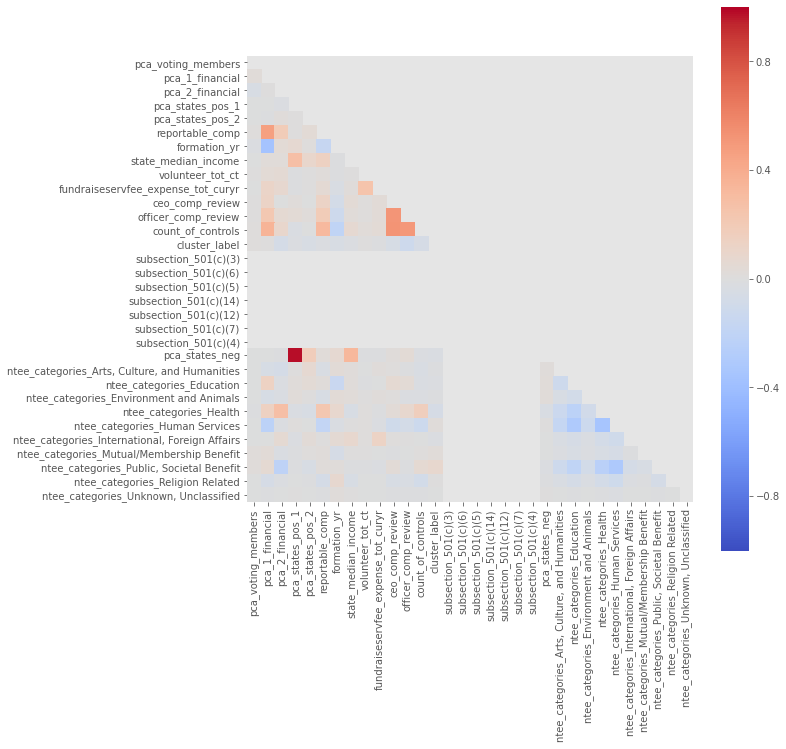

In [140]:
# show correlation heatmap, only displaying one half
# so information isn't duplicated
plt.figure(figsize=(10, 10))

mask = np.zeros_like(pd.get_dummies(df).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(pd.get_dummies(df).corr(),
            vmin=-1,
            cmap='coolwarm',
#             cmap="Blues",
            annot=False,
            square=True,
            mask = mask);

Almost all correlated features have been consolidated.

### Export dataset with feature adjustments

In [142]:
df.head()

,pca_voting_members,pca_1_financial,pca_2_financial,pca_states_pos_1,pca_states_pos_2,reportable_comp,formation_yr,state_median_income,ntee_categories,volunteer_tot_ct,fundraiseservfee_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,cluster_label,subsection_501(c)(3),subsection_501(c)(6),subsection_501(c)(5),subsection_501(c)(14),subsection_501(c)(12),subsection_501(c)(7),subsection_501(c)(4),pca_states_neg
0,74.050274,-8.108822e+07,-7.298222e+06,-0.085261,-0.082864,198085.0,1995,56277,"Public, Societal Benefit",0,0,False,False,7,181,False,False,False,False,False,False,False,-0.113183
1,-9.388241,-8.244004e+07,-8.357208e+06,-0.085261,-0.082864,87550.0,1911,56277,"Public, Societal Benefit",100,0,True,True,10,15,False,False,False,False,False,False,False,-0.113183
2,-13.630878,-8.053351e+07,-9.056408e+06,-0.085261,-0.082864,64575.0,1896,56277,"Arts, Culture, and Humanities",50,0,True,True,8,62,False,False,False,False,False,False,False,-0.113183
3,-10.802453,-8.289619e+07,-8.846579e+06,-0.085261,-0.082864,62180.0,1927,56277,"Public, Societal Benefit",4,0,True,True,9,59,False,False,False,False,False,False,False,-0.113183
4,6.168092,-8.150810e+07,-8.089854e+06,-0.085261,-0.082864,130513.0,1952,56277,"Public, Societal Benefit",145,0,True,True,12,180,False,False,False,False,False,False,False,-0.113183


In [141]:
# remove target feature and 
# export features for modeling
df.to_csv('02.data/model_dataset_features_eng.csv', index=False)